<a href="https://colab.research.google.com/github/joseph7104/-1INF46-Plan_Compras_Produccion/blob/master/notebooks/tuning/RF_TUNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tuning de **RandomForest** para Forecast de Ventas (diario por plato)

**Estructura:**
1. Imports y utilidades
2. Configuración general (rutas, columnas candidatas)
3. Carga de datos y detección automática (target + features)
4. Preparación de X/y (con orden temporal)
5. Validación temporal (TimeSeriesSplit)
6. Búsqueda de hiperparámetros (RandomizedSearchCV)
7. Reentrenamiento con mejores hiperparámetros
8. Métricas globales (MAE, RMSE, R², MAPE, sMAPE, Accuracy = 1−MAPE)
9. Importancia de variables
10. Visualización: Real vs. Predicho (últimos 300)
11. (Opcional) Curva de validación

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('✅ Imports OK')

✅ Imports OK


In [3]:
DATA_PATH = Path('data/processed/dataset_forecast_diario.csv')
DATE_COL = 'fecha'

TARGET_CANDIDATES = ['cantidad','ventas','ventas_total','venta_total','y','target','ventas_real']
BASE_EXOG_CANDIDATES = ['feriado','fin_de_semana','dow','mes','anio','dia']
SERIES_EXOG_CANDIDATES = [
    'lag_1','lag_7','lag_14','lag_28',
    'rolling_mean_7','rolling_std_7',
    'rolling_mean_14','rolling_std_14',
    'rolling_mean_28','rolling_std_28',
    'dow_sin','dow_cos','mes_sin','mes_cos'
]
EVENT_CAND_PREFIX = 'evento_'
CLIMA_PREFIXES = ['clima_', 'temp_', 'precip_', 'humedad', 'viento']
RANDOM_STATE = 42
print(f'📍 DATA_PATH = {DATA_PATH}')

📍 DATA_PATH = data/processed/dataset_forecast_diario.csv


In [4]:
def pick_first(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

def detect_regressors(df, exclude_cols):
    cols = [c for c in df.columns if c not in exclude_cols]
    base = [c for c in BASE_EXOG_CANDIDATES if c in cols]
    series = [c for c in SERIES_EXOG_CANDIDATES if c in cols]
    eventos = [c for c in cols if c.startswith(EVENT_CAND_PREFIX)]
    clima = []
    for p in CLIMA_PREFIXES:
        clima += [c for c in cols if c.startswith(p)]
    seen, regs = set(), []
    for c in base + series + eventos + clima:
        if c not in seen:
            regs.append(c); seen.add(c)
    return regs

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100.0

def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    sm = smape(y_true, y_pred)
    mp = mape(y_true, y_pred)
    acc = max(0.0, 100.0 - mp)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'sMAPE': sm, 'MAPE': mp, 'Accuracy(1-MAPE)': acc/100.0}
print('✅ Utilidades OK')

✅ Utilidades OK


In [5]:
assert DATA_PATH.exists(), f'No se encontró el archivo en {DATA_PATH}. Ajusta DATA_PATH.'
df = pd.read_csv(DATA_PATH)
assert DATE_COL in df.columns, f"No existe la columna de fecha '{DATE_COL}' en el dataset."
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
df = df.sort_values(DATE_COL).reset_index(drop=True)
cols = df.columns.tolist()
target_col = pick_first(TARGET_CANDIDATES, cols)
assert target_col is not None, 'No se pudo detectar la columna objetivo (ventas/cantidad).'
exclude = [DATE_COL, target_col]
regressors = detect_regressors(df, exclude_cols=exclude)
print(f'➡️ target_col = {target_col}')
print(f'➡️ regressors  = {regressors[:12]}{' ...' if len(regressors)>12 else ''}')
print('Shape:', df.shape)
df.head(3)

➡️ target_col = cantidad
➡️ regressors  = ['feriado', 'fin_de_semana', 'dow', 'mes', 'anio', 'dia', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_std_7'] ...
Shape: (21410, 42)


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
0,2021-01-15,1,18.0,468.0,2021,1,15,4,0,0,...,21.428571,5.711309,21.214286,5.937865,NaN,NaN,-0.433884,-0.900969,0.0,1.0
1,2021-01-15,3,17.0,510.0,2021,1,15,4,0,0,...,13.857143,3.804759,13.714286,4.286447,NaN,NaN,-0.433884,-0.900969,0.0,1.0
2,2021-01-15,9,4.0,72.0,2021,1,15,4,0,0,...,3.142857,1.573592,4.000000,2.183857,NaN,NaN,-0.433884,-0.900969,0.0,1.0


In [6]:
use_cols = [DATE_COL, target_col] + regressors
data = df[use_cols].dropna().reset_index(drop=True)
X = data[regressors].copy()
y = data[target_col].astype(float).copy()
print('✅ Dataset para modelado:', X.shape, 'features =', X.shape[1])

✅ Dataset para modelado: (21242, 38) features = 38


In [7]:
N_SPLITS = 3
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
print('⏱ TimeSeriesSplit con n_splits =', N_SPLITS)

⏱ TimeSeriesSplit con n_splits = 3


In [8]:
from scipy.stats import randint
rf_base = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)
distributions = {
    'n_estimators': randint(300, 800),
    'max_depth': randint(4, 14),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0],
    'bootstrap': [True, False]
}
search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=distributions,
    n_iter=40,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)
search.fit(X, y)
print('✅ Búsqueda completada')
print('➡️ Mejor conjunto de hiperparámetros:')
print(search.best_params_)
print('➡️ Mejor puntaje (MAE, CV):', -search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
✅ Búsqueda completada
➡️ Mejor conjunto de hiperparámetros:
{'bootstrap': True, 'max_depth': 7, 'max_features': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 446}
➡️ Mejor puntaje (MAE, CV): 3.260784275281663


In [9]:
best_params = search.best_params_
best_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params)
best_rf.fit(X, y)
y_pred = best_rf.predict(X)
metrics = eval_metrics(y, y_pred)
print('\n📊 MÉTRICAS GLOBALES (entrenamiento completo)')
for k, v in metrics.items():
    if 'Accuracy' in k:
        print(f"{k:20s}: {v*100:.2f} %")
    else:
        print(f"{k:20s}: {v:.4f}")


📊 MÉTRICAS GLOBALES (entrenamiento completo)
MAE                 : 3.0360
RMSE                : 4.1082
R2                  : 0.7676
sMAPE               : 32.3578
MAPE                : 42.5257
Accuracy(1-MAPE)    : 57.47 %


In [10]:
importances = pd.DataFrame({
    'Variable': regressors,
    'Importancia': best_rf.feature_importances_
}).sort_values('Importancia', ascending=False)
print('\n🌟 Top 15 variables más importantes:')
display(importances.head(15))
out_dir = Path('reports/metrics'); out_dir.mkdir(parents=True, exist_ok=True)
importances.to_csv(out_dir / 'rf_feature_importances.csv', index=False)
print('💾 Guardado:', out_dir / 'rf_feature_importances.csv')


🌟 Top 15 variables más importantes:


,Variable,Importancia
14,rolling_mean_28,0.769505
12,rolling_mean_14,0.137619
10,rolling_mean_7,0.035101
0,feriado,0.009369
1,fin_de_semana,0.007976
2,dow,0.007812
16,dow_sin,0.007506
15,rolling_std_28,0.007330
35,clima_Lluvioso,0.002960
11,rolling_std_7,0.001923


💾 Guardado: reports/metrics/rf_feature_importances.csv


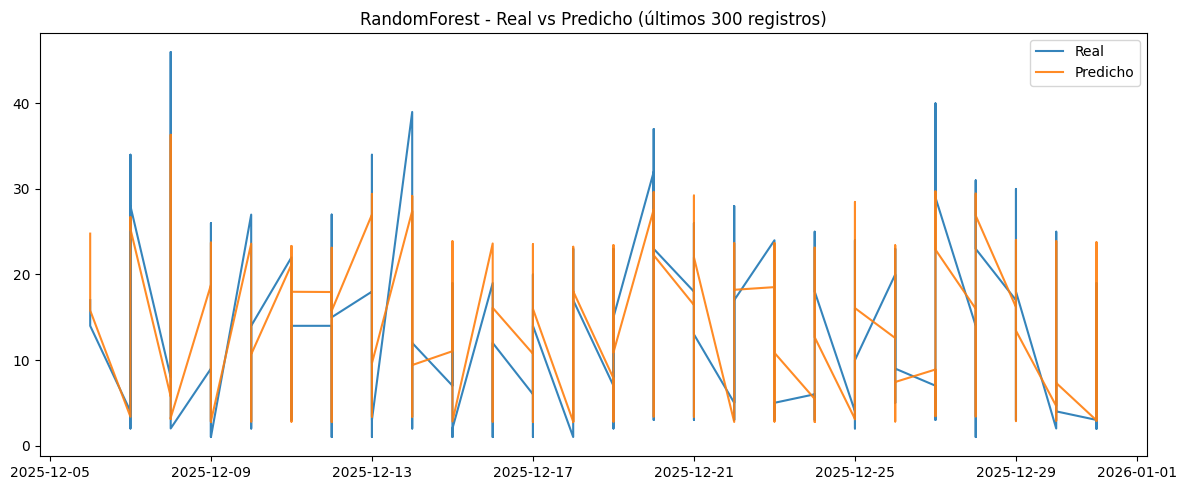

In [11]:
plt.figure(figsize=(12,5))
plt.plot(data[DATE_COL].iloc[-300:], y.iloc[-300:], label='Real', alpha=0.9)
plt.plot(data[DATE_COL].iloc[-300:], y_pred[-300:], label='Predicho', alpha=0.9)
plt.title('RandomForest - Real vs Predicho (últimos 300 registros)')
plt.legend()
plt.tight_layout()
plt.show()

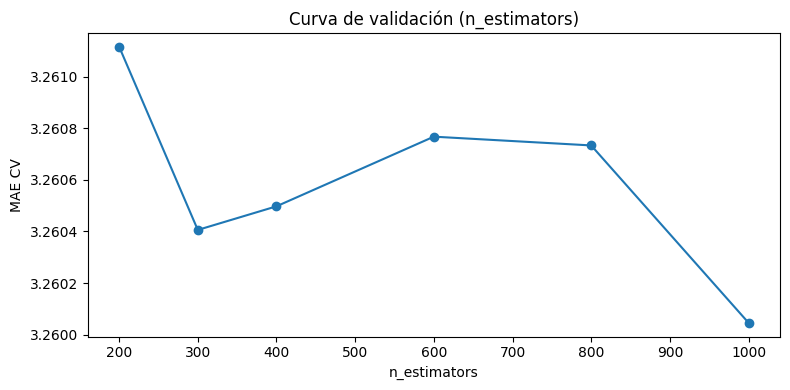

Valores evaluados: [(200, np.float64(3.261)), (300, np.float64(3.26)), (400, np.float64(3.26)), (600, np.float64(3.261)), (800, np.float64(3.261)), (1000, np.float64(3.26))]


In [12]:
vals = [200, 300, 400, 600, 800, 1000]
mae_cv = []
for v in vals:
    rf = RandomForestRegressor(
        n_estimators=v,
        random_state=42,
        n_jobs=-1,
        **{k: best_params[k] for k in best_params if k != 'n_estimators'}
    )
    scores = cross_val_score(rf, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    mae_cv.append(-scores.mean())

plt.figure(figsize=(8,4))
plt.plot(vals, mae_cv, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('MAE CV')
plt.title('Curva de validación (n_estimators)')
plt.tight_layout()
plt.show()
print('Valores evaluados:', list(zip(vals, [round(m,3) for m in mae_cv])))